In [1]:
# ✅ Configurar path para importar módulos desde src/
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))

In [2]:
# ✅ Instalación de dependencias necesarias para ejecutar este notebook
%pip install numpy==1.23.5 numba==0.56.4 matplotlib faker tqdm scikit-learn pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# 📖 Análisis de una Red Social Simulada

Este notebook demuestra la generación y análisis de una red social utilizando Programación Orientada a Objetos,
NumPy, Numba y algoritmos eficientes para sugerencias de amistad.

In [5]:
# 📆 Importar librerías necesarias
from utils.exceptions import UsuarioExistenteError, UsuarioNoEncontradoError
from utils.data_generator import generar_red_social
from models.network import RedSocial
from optimizations.optimized_ops import (
    calcular_amigos_en_comun,
    calcular_amigos_en_comun_numba,
    convertir_amigos_a_numpy
)
from algorithms.bfs import sugerencias_amistad
import matplotlib.pyplot as plt
import numpy as np
import json
from time import time
from pathlib import Path

In [7]:
# 💪 Ejecutar prueba sobre distintos escenarios
output_dir = Path('../outputs')
output_dir.mkdir(exist_ok=True)

resultados = []
escenarios = [10_000, 50_000, 100_000]

for n_usuarios in escenarios:
    print(f'🧪 Ejecutando prueba con {n_usuarios} usuarios')
    red_social = RedSocial()
    red_dict = generar_red_social(n_usuarios=n_usuarios, max_amigos=100)

    for usuario in red_dict:
        try:
            red_social.agregar_usuario(usuario)
        except UsuarioExistenteError:
            continue

    for usuario, amigos in red_dict.items():
        for amigo in amigos:
            try:
                red_social.conectar_usuarios(usuario, amigo)
            except UsuarioNoEncontradoError:
                continue

    red = red_social.obtener_red()
    usuarios = list(red.keys())
    user_a, user_b = usuarios[0], usuarios[1]
    amigos_a = red[user_a]
    amigos_b = red[user_b]
    amigos_np = convertir_amigos_a_numpy({user_a: amigos_a, user_b: amigos_b})

    tiempos = {'usuarios': n_usuarios, 'conjuntos': [], 'numba': []}

    for i in range(3):
        print(f'🔁 Iteración {i+1} con {n_usuarios} usuarios:')
        t0 = time()
        calcular_amigos_en_comun(amigos_a, amigos_b)
        t1 = time()
        tiempos['conjuntos'].append(t1 - t0)
        print(f'Amigos en común (conjuntos): {t1 - t0:.6f} segundos')

        t2 = time()
        calcular_amigos_en_comun_numba(amigos_np[user_a], amigos_np[user_b])
        t3 = time()
        tiempos['numba'].append(t3 - t2)
        print(f'Amigos en común (Numba): {t3 - t2:.6f} segundos')

    resultados.append(tiempos)

    if n_usuarios == 10_000:
        print(f'🔍 Sugerencias de amistad para {user_a}:')
        sugerencias = sugerencias_amistad(red_social, user_a, max_sugerencias=5)
        for i, nombre in enumerate(sugerencias, 1):
            print(f'{i}. {nombre}')

# Guardar JSON
with open(output_dir / 'resultados_tiempos.json', 'w') as f:
    json.dump(resultados, f, indent=4)

🧪 Ejecutando prueba con 10000 usuarios
🔁 Iteración 1 con 10000 usuarios:
Amigos en común (conjuntos): 0.000024 segundos
Amigos en común (Numba): 0.306435 segundos
🔁 Iteración 2 con 10000 usuarios:
Amigos en común (conjuntos): 0.000038 segundos
Amigos en común (Numba): 0.010193 segundos
🔁 Iteración 3 con 10000 usuarios:
Amigos en común (conjuntos): 0.000045 segundos
Amigos en común (Numba): 0.010414 segundos
🔍 Sugerencias de amistad para johnsonjoshua:
1. swalker
2. batesangela
3. ybutler
4. kristin46
5. jcoleman
🧪 Ejecutando prueba con 50000 usuarios
🔁 Iteración 1 con 50000 usuarios:
Amigos en común (conjuntos): 0.000015 segundos
Amigos en común (Numba): 0.011683 segundos
🔁 Iteración 2 con 50000 usuarios:
Amigos en común (conjuntos): 0.000015 segundos
Amigos en común (Numba): 0.005430 segundos
🔁 Iteración 3 con 50000 usuarios:
Amigos en común (conjuntos): 0.000010 segundos
Amigos en común (Numba): 0.005407 segundos
🧪 Ejecutando prueba con 100000 usuarios
🔁 Iteración 1 con 100000 usuari

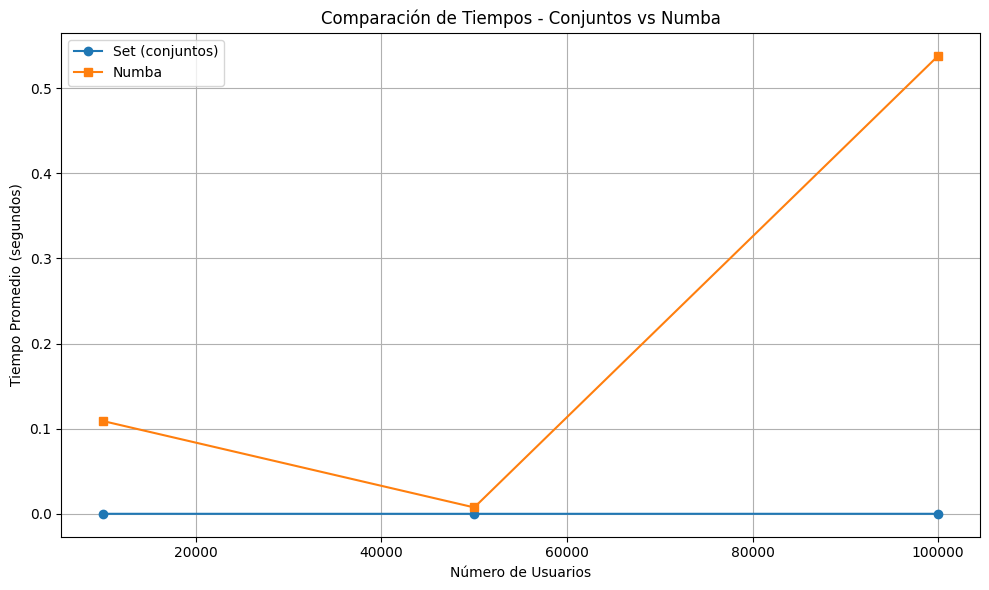

In [8]:
# 🌐 Visualizar resultados de tiempos
usuarios = [r['usuarios'] for r in resultados]
conjuntos_prom = [np.mean(r['conjuntos']) for r in resultados]
numba_prom = [np.mean(r['numba']) for r in resultados]

plt.figure(figsize=(10, 6))
plt.plot(usuarios, conjuntos_prom, label='Set (conjuntos)', marker='o')
plt.plot(usuarios, numba_prom, label='Numba', marker='s')
plt.title('Comparación de Tiempos - Conjuntos vs Numba')
plt.xlabel('Número de Usuarios')
plt.ylabel('Tiempo Promedio (segundos)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / 'grafico_comparacion_tiempos.png')
plt.show()